In [1]:
# 加载所需包
library(dplyr)
library(tidyr)
library(stringr)
library(purrr)
library(ggplot2)
library(zoo)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [2]:
all_event_wide_lists_withoutavg_1_8 <- readRDS("all_event_wide_lists_withoutavg_1_8.RDS")

In [3]:
data_list <- all_event_wide_lists_withoutavg_1_8[["SE"]][["Bombyx_mori"]]

In [4]:
meta_cols <- c("GeneID","geneSymbol","chr","strand",
               "exonStart_0base","exonEnd","upstreamES","upstreamEE","downstreamES","downstreamEE")
psi_cols <- setdiff(colnames(data_list), meta_cols)

In [5]:
data_long <- data_list %>%
  select(all_of(meta_cols), all_of(psi_cols)) %>%
  pivot_longer(
    cols      = all_of(psi_cols),
    names_to  = "Stage_Tissue",
    values_to = "PSI_string"
  )

In [6]:
data_long_parsed <- data_long %>%
  separate_rows(PSI_string, sep = ",") %>%
  mutate(PSI_value = as.numeric(PSI_string)) %>%
  filter(!is.na(PSI_value)) %>%
  group_by(GeneID, Stage_Tissue) %>%
  summarise(PSI_value = mean(PSI_value), .groups="drop")

In [7]:
data_long_parsed2 <- data_long_parsed %>%
  separate(
    col    = Stage_Tissue,
    into   = c("Stage","Stage-xifen", "Tissue"),
    sep    = "__",
    remove = FALSE
  )

In [8]:
# 统一 Stage 和 Tissue 命名
data_long_parsed2 <- data_long_parsed2 %>%
  mutate(
    Stage = case_when(
      Stage == "Cell" ~ "Egg",
      TRUE            ~ Stage
    )
  ) %>%
  mutate(
    Tissue = case_when(
      Tissue %in% c("Egg", "Pupa") ~ "Whole_body",
      TRUE                         ~ Tissue
    )
  )

In [9]:
stage_levels <- c("Egg", "Larva", "Pupa", "Adult")
data_long_parsed2 <- data_long_parsed2 %>%
  mutate(
    Stage = factor(Stage, levels = stage_levels),
    Combined_Stage = paste(Stage, `Stage-xifen`, sep = "-")
  ) %>%
  arrange(Stage, `Stage-xifen`)

In [10]:
saveRDS(data_long_parsed2, file = "data_long_parsed2.RDS")

In [31]:
get_earliest_stage_cor_bootstrap <- function(df_grouped, n_boot = 1000, seed = 123) {
  set.seed(seed)
  
  # 仅使用当前组织的数据
  tissue_name <- unique(df_grouped$Tissue)
  
  #（a）检查数据是否为空
  df_valid <- df_grouped %>%
    filter(!is.na(Stage), !is.na(`Stage-xifen`))
  if (nrow(df_valid) == 0) {
    return(
      tibble(
        Stage      = NA,
        `Stage-xifen` = NA,
        Tissue     = tissue_name,
        cor_median = NA_real_,
        cor_lower  = NA_real_,
        cor_upper  = NA_real_,
        n_genes    = NA_integer_
      )
    )
  }
  
  #（b）按 {Stage, Stage-xifen} 找到最早的时期
  earliest_stage <- df_valid %>%
    arrange(Stage, `Stage-xifen`) %>%  # 先按大时期，再按细分时期排序
    slice(1) %>%
    select(Stage, `Stage-xifen`) %>%
    mutate(Combined_Stage = paste(Stage, `Stage-xifen`, sep = "-"))  # 联合时期
  
  # 其他代码保持不变...
}


In [32]:
cor_all <- data_long_parsed2 %>%
  group_by(Tissue) %>%
  nest() %>%
  mutate(
    cor_table = map(
      data,
      ~ get_earliest_stage_cor_bootstrap(.x, n_boot = 1000, seed = 123)
    )
  ) %>%
  select(-data) %>%
  unnest(cols = cor_table)


Warning message:
“There were 15 warnings in `mutate()`.
The first warning was:
ℹ In argument: `cor_table = map(...)`.
ℹ In group 1: `Tissue = "Developmental_tissue"`.
Caused by warning:
! Unknown or uninitialised column: `Tissue`.
ℹ Run `dplyr::last_dplyr_warnings()` to see the 14 remaining warnings.”


In [34]:
# 先数一下每个Tissue的阶段有多少个
tissue_stage_count <- cor_all %>%
  group_by(Tissue) %>%
  summarise(n_stage = n_distinct(Stage))

In [35]:
# 找到至少有3个不同Stage的组织
valid_tissue <- tissue_stage_count %>%
  filter(n_stage >= 2) %>%
  pull(Tissue)

In [36]:
# 筛选 cor_all
cor_all <- cor_all %>%
  filter(Tissue %in% valid_tissue)

In [37]:
cor_all <- cor_all %>%
  mutate(Combined_Stage = paste(Stage, `Stage-xifen`, sep = "-"))

In [38]:
cor_all <- cor_all %>%
  mutate(
    Combined_Stage = factor(
      Combined_Stage,
      levels = unique(data_long_parsed2$Combined_Stage)  # 确保顺序一致
    )
  )

In [39]:
custom_order <- c(
  "Egg-0_days", "Egg-20-22_hours", "Egg-24_hours", "Egg-1_day", "Egg-2_days",  "Egg-36_hours", "Egg-3_days", "Egg-72_hours", "Egg-120_hours","Egg-168_hours",  "Egg-192_hours", "Egg-216_hours", 
  "Larva-0_hours", "Larva-1_day_of_1_instar", "Larva-48_hours", "Larva-96_hours" , "Larva-1_instar", "Larva-2_instar", "Larva-0_day_of_3_instar", "Larva-24_hours_of_4_instar", "Larva-1_day_of_4_instar", "Larva-2_day_of_4_instar", "Larva-3_day_of_4_instar", "Larva-4_day_of_4_instar", "Larva-4_instar" , "Larva-10_day_of_4_instar", "Larva-11_day_of_4_instar", "Larva-12_day_of_4_instar", "Larva-0_day_of_5_instar", "Larva-1_day_of_5_instar", "Larva-2_day_of_5_instar", "Larva-3_day_of_5_instar", "Larva-4_day_of_5_instar", "Larva-5_instar","Larva-6_day_of_5_instar", "Larva-7_day_of_5_instar", "Larva-8_day_of_5_instar" , "Larva-9_day_of_5_instar", "Larva-10_day_of_5_instar", "Larva-12_day_of_5_instar", "Larva-13_day_of_5_instar", "Larva-14_day_of_5_instar", "Larva-15_day_of_5_instar", "Larva-wandering_stage", "Larva-36h_wandering_stage","Larva-52h_wandering_stage", 
  "Pupa-stage_5", 
  "Adult-0h","Adult-1_day", "Adult-2_days", "Adult-4_days","Adult-5_days"
)

In [40]:
# 从数据中过滤掉不需要的时期
data_long_parsed2 <- data_long_parsed2 %>%
  filter(Combined_Stage %in% custom_order)

In [41]:
cor_all <- cor_all %>%
  filter(Combined_Stage %in% custom_order)
data_long_parsed2 <- data_long_parsed2 %>%
  mutate(
    Combined_Stage = factor(
      Combined_Stage,
      levels = custom_order  # 手动指定顺序
    )
  )

In [42]:
cor_all <- cor_all %>%
  mutate(
    Combined_Stage = factor(
      Combined_Stage,
      levels = custom_order  # 保持顺序一致
    )
  )

In [43]:
# 设置置信区间范围阈值
threshold <- 0.5

In [44]:
# 剔除置信区间范围过大的点
cor_all_filtered <- cor_all %>%
  filter((cor_upper - cor_lower) <= threshold | is.na(cor_upper - cor_lower))


ERROR: [1m[33mError[39m in `filter()`:[22m
[1m[22m[36mℹ[39m In argument: `(cor_upper - cor_lower) <= threshold | is.na(cor_upper - cor_lower)`.
[1mCaused by error:[22m
[33m![39m object 'cor_upper' not found


In [45]:
library(zoo)


In [47]:
# 对每个 Tissue 分组，进行插值平滑处理
cor_all_smoothed <- cor_all_filtered %>%
  group_by(Tissue) %>%
  mutate(
    cor_median_smooth = na.approx(cor_median, na.rm = FALSE),  # 平滑中位数
    cor_lower_smooth = na.approx(cor_lower, na.rm = FALSE),    # 平滑下界
    cor_upper_smooth = na.approx(cor_upper, na.rm = FALSE)     # 平滑上界
  ) %>%
  ungroup()

In [48]:
p <- # 用平滑后的数据进行绘图
  ggplot(cor_all_smoothed, aes(x = Combined_Stage, y = cor_median_smooth, group = Tissue, color = Tissue)) +
  geom_ribbon(aes(ymin = cor_lower_smooth, ymax = cor_upper_smooth, fill = Tissue), alpha = 0.2, color = NA) +
  geom_line() +
  geom_point() +
  theme_bw(base_size = 14) +
  labs(
    title = "PSI correlation with filtered and smoothed confidence intervals",
    x = "Stage",
    y = "Pearson correlation (median ± 95% CI)"
  ) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  )



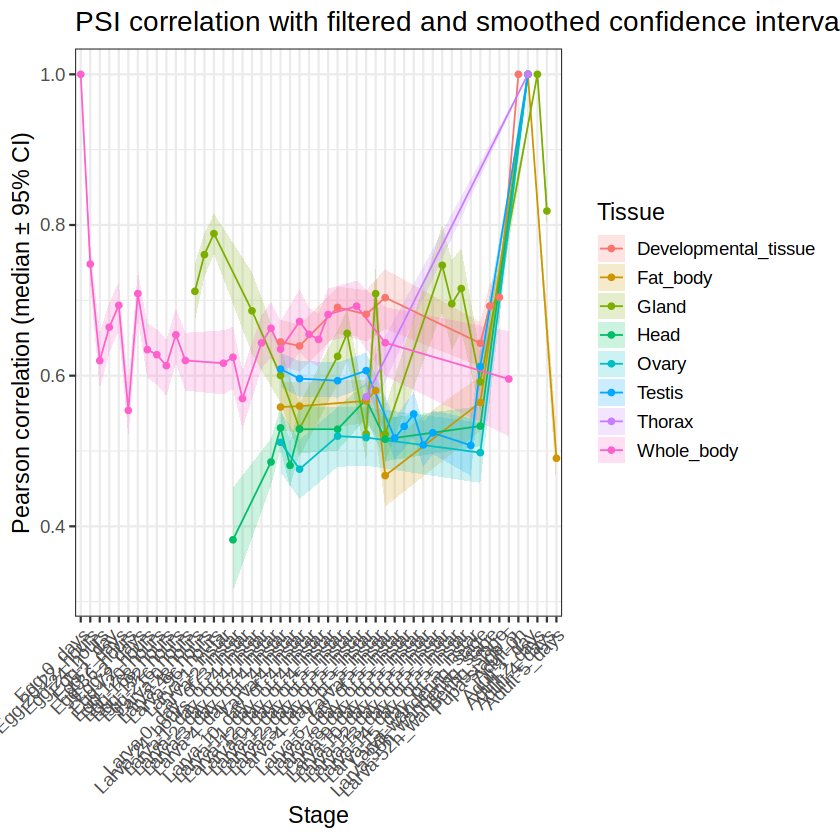

In [49]:
print(p)